In [251]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [252]:
dataset = pd.read_csv('sp500_enriquecido.csv')

In [253]:
dataset = dataset.dropna()
dataset

,Date,Adj_close,DateOrdinal,average_price,DayOfWeek,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,...,Up_Last_30,Down_Last_30,Up_Last_7,Down_Last_7,Up_Last_14,Down_Last_14,Up_Streak,Down_Streak,Max_Up_Streak_30,Max_Down_Streak_30
0,2018-01-02,2695.81,20180102,2689.125,1,2,1,0,0,1,...,11.0,8.0,2.0,2.0,3.0,5.0,1,0,5.0,2.0
1,2018-01-03,2713.06,20180103,2706.070,2,3,1,0,0,1,...,12.0,8.0,3.0,1.0,4.0,4.0,2,0,5.0,2.0
2,2018-01-04,2723.99,20180104,2724.180,3,4,1,0,0,1,...,12.0,8.0,3.0,1.0,5.0,3.0,3,0,5.0,2.0
3,2018-01-05,2743.15,20180105,2735.685,4,5,1,0,0,1,...,13.0,7.0,3.0,1.0,5.0,3.0,4,0,5.0,2.0
4,2018-01-08,2747.71,20180108,2743.055,0,8,2,0,0,1,...,12.0,6.0,4.0,0.0,6.0,2.0,5,0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2020-12-24,3703.06,20201224,3696.570,3,359,52,0,0,4,...,14.0,7.0,3.0,2.0,6.0,4.0,0,1,5.0,3.0
752,2020-12-28,3735.36,20201228,3731.770,0,363,53,0,0,4,...,11.0,8.0,2.0,2.0,6.0,3.0,1,0,4.0,3.0
753,2020-12-29,3727.04,20201229,3739.715,1,364,53,0,0,4,...,12.0,8.0,3.0,1.0,6.0,3.0,2,0,4.0,3.0
754,2020-12-30,3732.04,20201230,3737.420,2,365,53,0,0,4,...,13.0,8.0,3.0,1.0,6.0,3.0,0,1,4.0,3.0


In [254]:
calculatedFields = [col for col in dataset.columns if col not in ['Date', 'average_price']]
fieldsPrice = ["average_price"]
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [255]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [256]:
from datetime import datetime

random_date = datetime.strptime("01/01/2018", "%d/%m/%Y")

In [257]:
filtered_df = dataset[(dataset['Date'] >= random_date)]

In [258]:
testRanges = [1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361]
train_days = 365
nJobs = 5
nEstimators = 100
block_size = 5

In [259]:
def getTrainTest(filtered_df0, pivote_date0, head=29):
    max_train_day = pivote_date0 + pd.DateOffset(days=train_days)
    blockDf = filtered_df0[(filtered_df0['Date'] >= pivote_date0) & (filtered_df0['Date'] <= max_train_day)]
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_train0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_train0 = aux[fieldsPrice].copy()
    
    #Se toman los siguientes 29 días hábiles
    blockDf = filtered_df0[filtered_df0["Date"] > max_train_day].head(head)
    #filtered_df0[(filtered_df0['Date'] > max_train_day) & (filtered_df0['Date'] <= max_test_day)]
    
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_test0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test0 = aux[fieldsPrice].copy()

    return X_train0, Y_train0, X_test0, Y_test0

In [260]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [261]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

predictedBasicRF_2 = []
predictedNonOverlapping_2 = []
predictedMovingBlock_2 = []
predictedCircularBlock_2 = []

predictedBasicRF = []
predictedNonOverlapping = []
predictedMovingBlock = []
predictedCircularBlock = []

In [262]:
expectedValuesMean = []
expectedValues = []
pivote_date = random_date
for testRange in testRanges[:6]:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    expectedValuesMean.append(sum(Y_test.head(7)["average_price"].tolist()) / len(Y_test.head(7)["average_price"].tolist()))
    expectedValues += Y_test.head(7)["average_price"].tolist()
    basicRFPrecision[testRange] = rmse0
    X_test0 = X_test.tail(22)
    Y_test0 = Y_test.tail(22)
    y_pred = basicRF.predict(X_test0.head(7))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    expectedValuesMean.append(sum(Y_test0.head(7)["average_price"].tolist()) / len(Y_test0.head(7)["average_price"].tolist()))
    expectedValues += Y_test0.head(7)["average_price"].tolist()
    basicRFPrecision[testRange + 7] = rmse0
    X_test1 = X_test.tail(15)
    Y_test1 = Y_test.tail(15)
    y_pred = basicRF.predict(X_test1.head(7))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    expectedValuesMean.append(sum(Y_test1.head(7)["average_price"].tolist()) / len(Y_test1.head(7)["average_price"].tolist()))
    expectedValues += Y_test1.head(7)["average_price"].tolist()
    basicRFPrecision[testRange + 14] = rmse0
    X_test2 = X_test.tail(8)
    Y_test2 = Y_test.tail(8)
    y_pred = basicRF.predict(X_test2.head(7))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    expectedValuesMean.append(sum(Y_test2.head(7)["average_price"].tolist()) / len(Y_test2.head(7)["average_price"].tolist()))
    expectedValues += Y_test2.head(7)["average_price"].tolist()
    basicRFPrecision[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    precisionNonOverlapping[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionNonOverlapping[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionNonOverlapping[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionNonOverlapping[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    precisionMovingBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionMovingBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionMovingBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionMovingBlock[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    precisionCircularBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionCircularBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionCircularBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionCircularBlock[testRange + 21] = rmse0
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

In [263]:
ticks001 = []
for testRange in testRanges[:6]:
    ticks001.append("")
    ticks001.append(str(testRange))
    for i in range(5):
        ticks001.append("")
    ticks001.append(str(testRange + 7))
    for i in range(6):
        ticks001.append("")
    ticks001.append(str(testRange + 14))
    for i in range(6):
        ticks001.append("")
    ticks001.append(str(testRange + 21))
    for i in range(8):
        ticks001.append("")

rmse_y = []
prediction_y = []
for i in testRanges[:6]:
    rmse_y += [i]
    for k in range(7):
        prediction_y += [i + k]
    rmse_y += [i + 7]
    for k in range(7):
        prediction_y += [i + k + 7]
    rmse_y += [i + 14]
    for k in range(7):
        prediction_y += [i + k + 14]
    rmse_y += [i + 21]
    for k in range(7):
        prediction_y += [i + k + 21]

In [264]:
def calculate_percent_error(rmse, predicted):
    percent_error = []
    k = 0
    for i in range(len(rmse)):
        exp = 0
        for x in range(7):
            try:
                exp += predicted[k]
                k += 1
            except:
                print()
        exp /= 7
        percent_error.append((rmse[i] / exp) * 100) 
    return percent_error

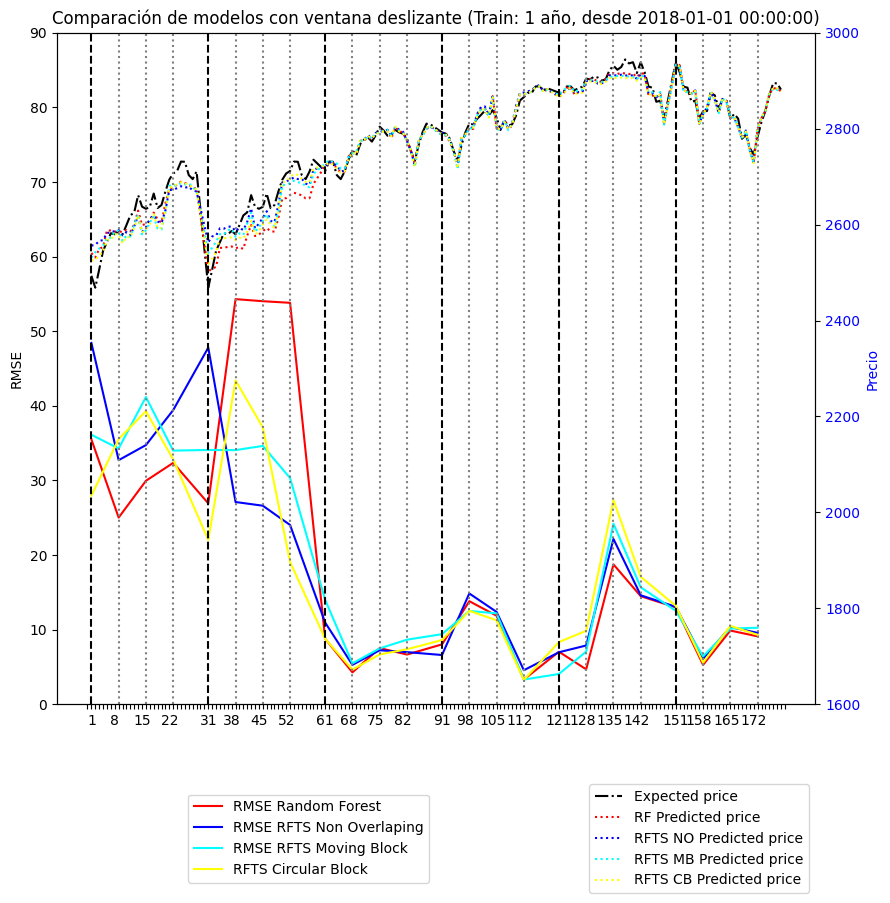

In [265]:
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())

fig, ax1 = plt.subplots(figsize=(9, 9))
bp3 = ax1.plot(rmse_y, all_arr0, color='red', label="RMSE Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = ax1.plot(rmse_y, all_arr, color='blue', label="RMSE RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = ax1.plot(rmse_y, all_arr1, color='cyan', label="RMSE RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = ax1.plot(rmse_y, all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
plt.legend(loc='center right', bbox_to_anchor=(0.5, -0.2))
plt.ylabel("RMSE")
ax1.set_ylim(0, 90)
# Segundo eje
ax2 = ax1.twinx()
ax2.plot(prediction_y, expectedValues, color='black', label="Expected price", linestyle='-.')
ax2.plot(prediction_y, predictedBasicRF_2, color='red', label="RF Predicted price", linestyle=':')
ax2.plot(prediction_y, predictedNonOverlapping_2, color='blue', label="RFTS NO Predicted price", linestyle=':')
ax2.plot(prediction_y, predictedMovingBlock_2, color='cyan', label="RFTS MB Predicted price", linestyle=':')
ax2.plot(prediction_y, predictedCircularBlock_2, color='yellow', label="RFTS CB Predicted price", linestyle=':')
ax2.set_ylabel('Precio', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylim(1600, 3000)
plt.legend(loc='center right', bbox_to_anchor=(1, -0.2))


plt.xticks(range(0, len(ticks001)), ticks001)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=-45)

i = 0
for testRange in testRanges[:6]:
    plt.axvline(x=testRange, color='black', linestyle='--')
    for k in range(3):
        plt.axvline(x=testRange + (k + 1) * 7, color='grey', linestyle=':')
    i+=1

plt.show()

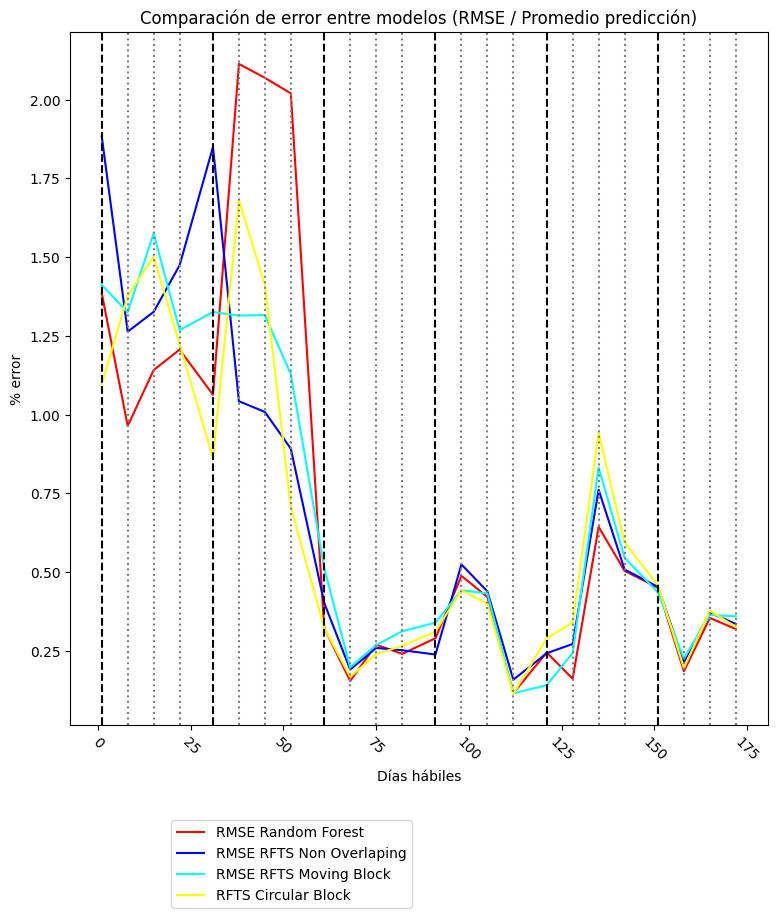

In [266]:
rf_error = calculate_percent_error(all_arr0, predictedBasicRF_2)
rfts_no_error = calculate_percent_error(all_arr, predictedNonOverlapping_2)
rfts_mb_error = calculate_percent_error(all_arr1, predictedMovingBlock_2)
rfts_cb_error = calculate_percent_error(all_arr2, predictedCircularBlock_2)

fig, ax1 = plt.subplots(figsize=(9, 9))
bp3 = ax1.plot(rmse_y, rf_error, color='red', label="RMSE Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = ax1.plot(rmse_y, rfts_no_error, color='blue', label="RMSE RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = ax1.plot(rmse_y, rfts_mb_error, color='cyan', label="RMSE RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = ax1.plot(rmse_y, rfts_cb_error, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
plt.legend(loc='center right', bbox_to_anchor=(0.5, -0.2))
plt.ylabel("% error")
plt.xlabel("Días hábiles")
plt.title(f"Comparación de error entre modelos (RMSE / Promedio predicción)")
plt.xticks(rotation=-45)

i = 0
for testRange in testRanges[:6]:
    plt.axvline(x=testRange, color='black', linestyle='--')
    for k in range(3):
        plt.axvline(x=testRange + (k + 1) * 7, color='grey', linestyle=':')
    i+=1